In [16]:
# Hardware and user spercifications
import platform
import psutil
import getpass

# --- Setup: Imports ---
import os, seaborn as sns, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import shuffle

# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# --- Data Loading and Preprocessing ---

# Load the dataset
from ucimlrepo import fetch_ucirepo

In [6]:
# fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X = phishing_websites.data.features
Y = phishing_websites.data.targets

X = X.select_dtypes(include=[np.number])

# Map target labels: -1 -> 0, 0 -> 1, 1 -> 2 (Pytorch's CrossEntropyLoss() does not accept negative targets)
Y = Y.replace({-1: 0, 0: 1, 1: 2})

# Split the data (80% train, 20% validation). Set random_state = random_seed.
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=random_seed)

# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
X_val_t = torch.tensor(X_val.values, dtype=torch.float32)
y_train_t = torch.tensor(Y_train.values, dtype=torch.long).view(-1)
y_val_t = torch.tensor(Y_val.values, dtype=torch.long).view(-1)

print(f"Training features shape: {X_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")

Training features shape: torch.Size([8844, 30])
Validation features shape: torch.Size([2211, 30])


In [7]:
# --- Model Definition ---
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(30, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- 3. Model Class Defined ---")


def calculate_full_loss(model, criterion, X, y):
    """Helper function to calculate loss over an entire dataset."""
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(X)
        loss = criterion(outputs, y)
    model.train()  # Set model back to train mode
    return loss.item()


def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                         num_iterations, batch_size, check_every):
    train_losses = []
    val_losses = []
    iterations = []

    for i in range(1, num_iterations + 1):

        # Pick one random sample batch
        rand_index = np.random.choice(X_train.shape[0], batch_size, replace=False)
        rand_X_batch = X_train[rand_index]
        rand_y_batch = y_train[rand_index].long().view(-1)

        # Predict
        optimizer.zero_grad()
        outputs = model(rand_X_batch)

        # Compute loss
        loss = criterion(outputs, rand_y_batch)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Check progress
        if i % check_every == 0:
            train_loss = calculate_full_loss(model, criterion, X_train, y_train)
            val_loss = calculate_full_loss(model, criterion, X_val, y_val)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            iterations.append(i)

            print(f"Iteration {i}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

    return train_losses, val_losses, iterations, model


# --- Set Hyperparameters ---
LEARNING_RATE = 0.01
NUM_ITERATIONS = 3000
BATCH_SIZE = 32
CHECK_EVERY = round(NUM_ITERATIONS / 10)

# --- Model Initialization ---
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)  # changed this line to make it L2 regularization

# --- Run Minibatch Training ---
train_losses, val_losses, iterations, model = train_with_minibatch(
    model, criterion, optimizer,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS, BATCH_SIZE, CHECK_EVERY
)

Model will accept 30 input features.
--- 3. Model Class Defined ---
Iteration 300: train loss = 0.6236, val loss = 0.6228
Iteration 600: train loss = 0.2826, val loss = 0.2836
Iteration 900: train loss = 0.2166, val loss = 0.2183
Iteration 1200: train loss = 0.1981, val loss = 0.2025
Iteration 1500: train loss = 0.1900, val loss = 0.1978
Iteration 1800: train loss = 0.1854, val loss = 0.1951
Iteration 2100: train loss = 0.1817, val loss = 0.1919
Iteration 2400: train loss = 0.1802, val loss = 0.1911
Iteration 2700: train loss = 0.1788, val loss = 0.1910
Iteration 3000: train loss = 0.1783, val loss = 0.1920


Plotting...


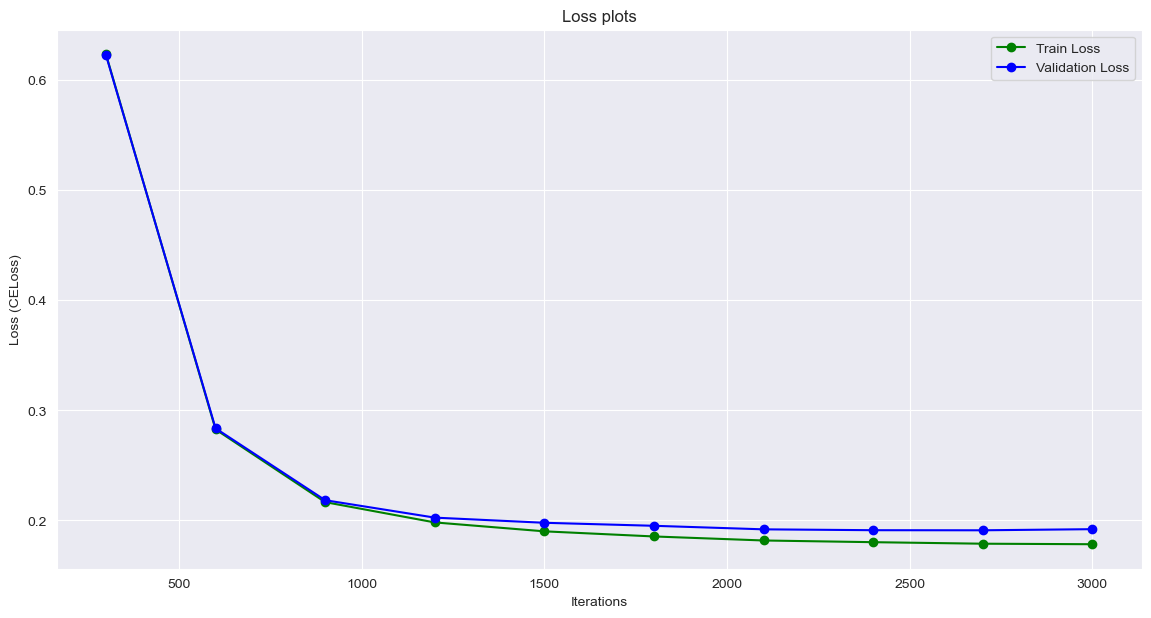

In [8]:
# --- Plotting ---
print("Plotting...")
plt.figure(figsize=(14, 7))

plt.plot(iterations, train_losses, label='Train Loss', linestyle='-', color='green', marker='o')
plt.plot(iterations, val_losses, label='Validation Loss', linestyle='-', color='blue', marker='o')

plt.title('Loss plots')
plt.xlabel('Iterations')
plt.ylabel('Loss (CELoss)')
plt.legend()
plt.grid(True)
plt.show()


Training Metrics:
Accuracy: 0.9316, Precision: 0.9308, Recall: 0.9307, F1-score: 0.9308


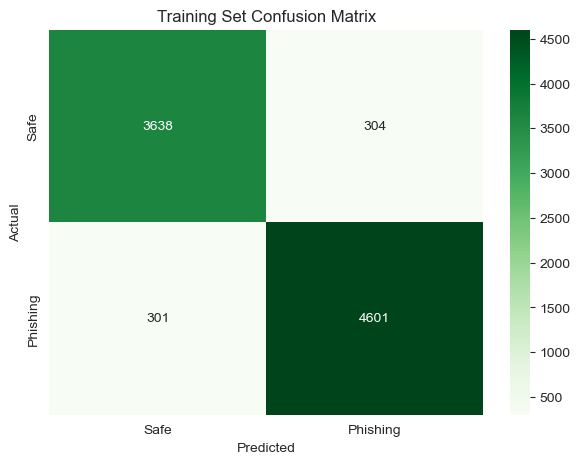

In [9]:
# --- Evaluate on training set ---
model.eval()
with torch.no_grad():
    y_train_pred = torch.argmax(model(X_train_t), dim=1)

# Map to readable labels
y_train_pred_label = ['Safe' if x==0 else 'Phishing' for x in y_train_pred.numpy()]
y_train_label = ['Safe' if x==0 else 'Phishing' for x in y_train_t.numpy()]

train_acc = accuracy_score(y_train_label, y_train_pred_label)
train_prec = precision_score(y_train_label, y_train_pred_label, average='macro')
train_rec = recall_score(y_train_label, y_train_pred_label, average='macro')
train_f1 = f1_score(y_train_label, y_train_pred_label, average='macro')

print(f"\nTraining Metrics:\nAccuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1-score: {train_f1:.4f}")

# --- Confusion Matrix for Training Set ---
cm_train = confusion_matrix(y_train_label, y_train_pred_label, labels=['Safe','Phishing'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=['Safe','Phishing'], yticklabels=['Safe','Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Set Confusion Matrix')
plt.show()


Validation Metrics:
Accuracy: 0.9240, Precision: 0.9223, Recall: 0.9231, F1-score: 0.9227


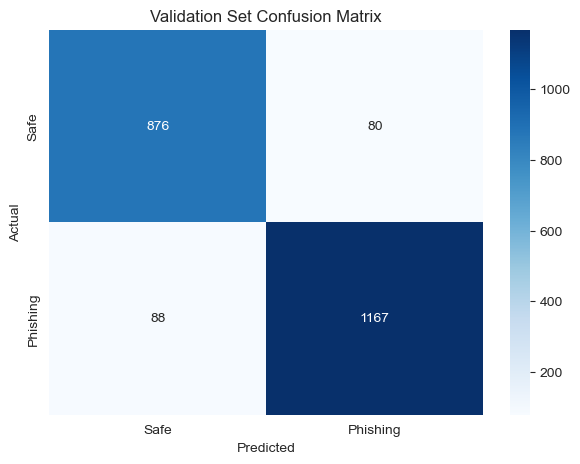

In [11]:
# --- Evaluate on validation set ---
model.eval()
with torch.no_grad():
    y_val_pred = torch.argmax(model(X_val_t), dim=1)

# Map to readable labels
y_val_pred_label = ['Safe' if x==0 else 'Phishing' for x in y_val_pred.numpy()]
y_val_label = ['Safe' if x==0 else 'Phishing' for x in y_val_t.numpy()]

# --- Calculate basic metrics ---
acc = accuracy_score(y_val_label, y_val_pred_label)
prec = precision_score(y_val_label, y_val_pred_label, average='macro')
rec = recall_score(y_val_label, y_val_pred_label, average='macro')
f1 = f1_score(y_val_label, y_val_pred_label, average='macro')
print(f"\nValidation Metrics:\nAccuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# --- Confusion Matrix Heatmap ---
cm_val = confusion_matrix(y_val_label, y_val_pred_label, labels=['Safe','Phishing'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe','Phishing'], yticklabels=['Safe','Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Set Confusion Matrix')
plt.show()

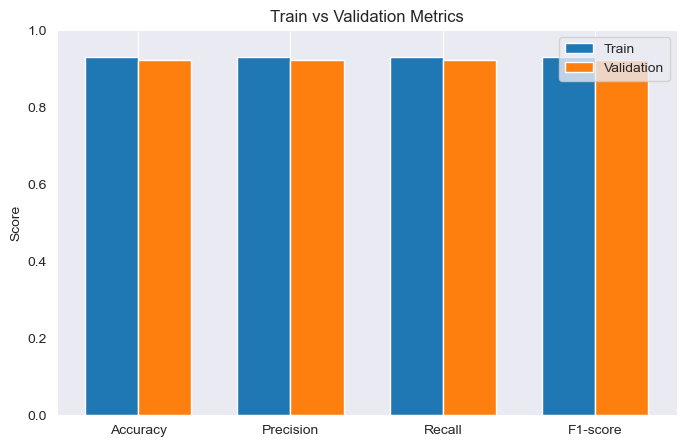

In [12]:
# --- Plot Train vs Validation metrics ---
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
train_values = [train_acc, train_prec, train_rec, train_f1]
val_values = [acc, prec, rec, f1]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, train_values, width, label='Train')
plt.bar(x + width/2, val_values, width, label='Validation')
plt.ylabel('Score')
plt.title('Train vs Validation Metrics')
plt.xticks(x, metrics)
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y')
plt.show()

Number of suspicious (0) instances per feature:
 having_ip_address                0
url_length                     108
shortining_service               0
having_at_symbol                 0
double_slash_redirecting         0
prefix_suffix                    0
having_sub_domain             2891
sslfinal_state                 945
domain_registration_length       0
favicon                          0
port                             0
https_token                      0
request_url                      0
url_of_anchor                 4247
links_in_tags                 3545
sfh                            610
submitting_to_email              0
abnormal_url                     0
redirect                      7823
on_mouseover                     0
rightclick                       0
popupwindow                      0
iframe                           0
age_of_domain                    0
dnsrecord                        0
web_traffic                   2064
page_rank                        0
google

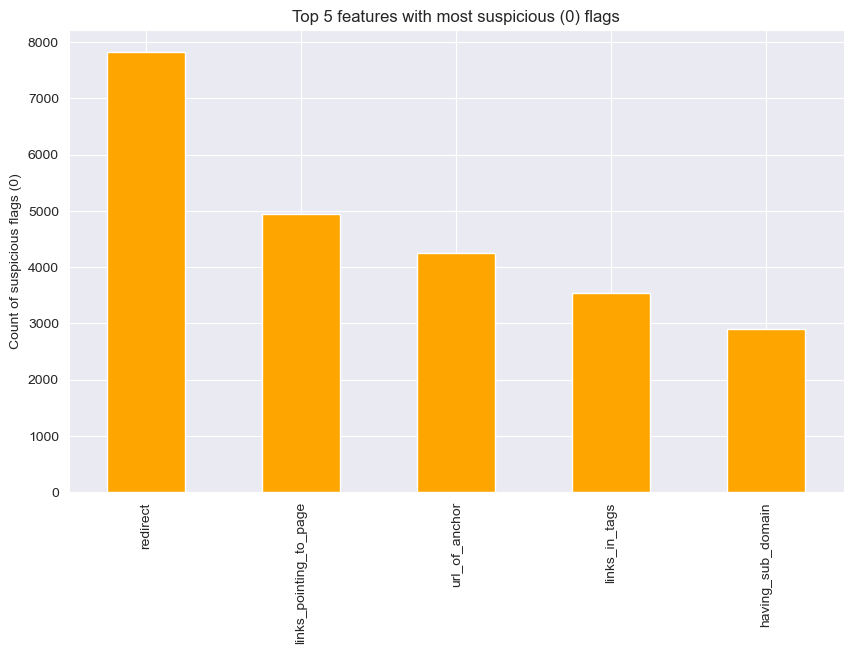

In [14]:
# Map Result back to readable labels
Y_label = Y.replace({-1: 'Safe', 1: 'Phishing', 0: 'Suspicious'})  # optional if 0 is used in target

# Features that indicate suspicion (0) per class
# Initialize a counter for each feature
suspicious_counts = pd.Series(0, index=X_train.columns)

# Traverse each row and each column
for idx, row in X_train.iterrows():
    for col in X_train.columns:
        if row[col] == 0:
            suspicious_counts[col] += 1

print("Number of suspicious (0) instances per feature:\n", suspicious_counts)

# Optional: Plot top 10 features with most suspicious flags
top_features = suspicious_counts.sort_values(ascending=False).head(5)
top_features.plot(kind='bar', figsize=(10,6), color='orange')
plt.title("Top 5 features with most suspicious (0) flags")
plt.ylabel("Count of suspicious flags (0)")
plt.show()

Mutual information of features with target:
 sslfinal_state                0.347930
url_of_anchor                 0.329453
prefix_suffix                 0.094439
web_traffic                   0.079505
having_sub_domain             0.076475
sfh                           0.034943
request_url                   0.032272
links_in_tags                 0.027058
domain_registration_length    0.024397
google_index                  0.015761
page_rank                     0.013585
having_at_symbol              0.008461
iframe                        0.006776
on_mouseover                  0.006687
age_of_domain                 0.006367
statistical_report            0.003907
rightclick                    0.003732
https_token                   0.003239
having_ip_address             0.003066
links_pointing_to_page        0.002529
submitting_to_email           0.001993
abnormal_url                  0.001579
shortining_service            0.001397
url_length                    0.000820
double_slash_redire

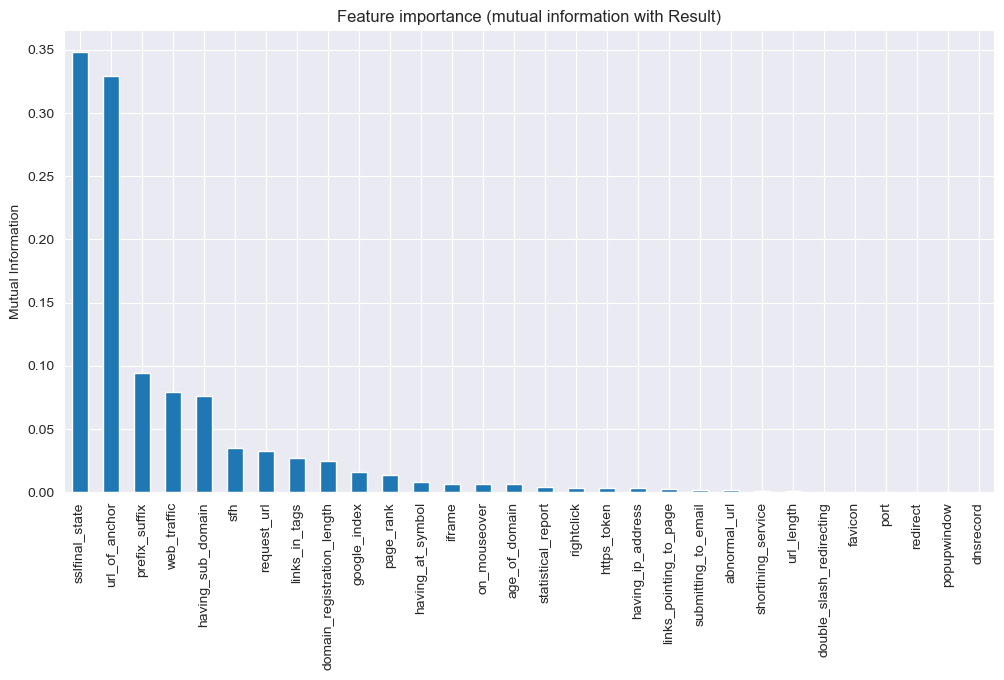

In [17]:
# Feature-class dependency using correlation
# Since features are discrete (-1,0,1) and target is categorical, use point biserial or mutual info
mi = mutual_info_classif(X_train, Y_train.values.ravel())
feature_mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual information of features with target:\n", feature_mi)

# Optional plot
feature_mi.plot(kind='bar', figsize=(12,6))
plt.title("Feature importance (mutual information with Result)")
plt.ylabel("Mutual Information")
plt.show()